<a href="https://colab.research.google.com/github/Salman1450/CXR-and-MRI/blob/main/MRI_End_to_End.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#First Run the segmentation then classification then annotation.
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD
import scipy  #Used to upsample our image

import os
import cv2
from PIL import Image
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_directory = '/content/drive/MyDrive/Nickparver_156MB/Training/'
SIZE = 224
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
label = []  #Placeholders to define add labels. We will add [0,1,2,3] to [glioma,meningioma,no tumor,pituitary]

In [ ]:
glioma_images = os.listdir(image_directory + 'glioma/')
for i, image_name in enumerate(glioma_images):    
    
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(image_directory + 'glioma/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)



meningioma_images = os.listdir(image_directory + 'meningioma/')
for i, image_name in enumerate(meningioma_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(image_directory + 'meningioma/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)

notumor_images = os.listdir(image_directory + 'notumor/')
for i, image_name in enumerate(notumor_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(image_directory + 'notumor/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(2)

pituitary_images = os.listdir(image_directory + 'pituitary/')
for i, image_name in enumerate(pituitary_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(image_directory + 'pituitary/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(3)

In [ ]:
dataset = np.array(dataset)
label = np.array(label)

In [ ]:
#Split into train and test data sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = 0)

In [ ]:
#Let us setup the model as multiclass with total classes as 4.
#This way the model can be used for other multiclass examples. 
#Since we will be using categorical cross entropy loss, we need to convert our Y values to categorical. 
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
#Define the model. 
#Here, we use pre-trained VGG16 layers and add GlobalAveragePooling and dense prediction layers.
#You can define any model. 
#Also, here we set the first few convolutional blocks as non-trainable and only train the last block.
#This is just to speed up the training. You can train all layers if you want. 
def get_model(input_shape = (224,224,3)):
    
    vgg = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = input_shape)

    
    for layer in vgg.layers[:-5]:    #Set block5 trainable, all others as non-trainable
        print(layer.name)
        layer.trainable = False #All others as non-trainable.

    x = vgg.output
    x = GlobalAveragePooling2D()(x) #Use GlobalAveragePooling and NOT flatten. 
    x = Dense(4, activation="softmax")(x)  #We are defining this as multiclass problem. 

    model = Model(vgg.input, x)
    model.compile(loss = "categorical_crossentropy", 
                  optimizer = SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
    
    return model
   
model = get_model(input_shape = (224,224,3))
print(model.summary())

58889256/58889256 [==============================] - 4s 0us/step
input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                    

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(X_train, y_train, batch_size=16, epochs=10, verbose = 1, 
                    validation_data=(X_test,y_test))

Epoch 1/10
288/288 [==============================] - 39s 127ms/step - loss: 0.4209 - accuracy: 0.8597 - val_loss: 0.2150 - val_accuracy: 0.9270
Epoch 2/10
288/288 [==============================] - 32s 111ms/step - loss: 0.1398 - accuracy: 0.9511 - val_loss: 0.1997 - val_accuracy: 0.9288
Epoch 3/10
288/288 [==============================] - 32s 112ms/step - loss: 0.0720 - accuracy: 0.9776 - val_loss: 0.1239 - val_accuracy: 0.9609
Epoch 4/10
288/288 [==============================] - 33s 114ms/step - loss: 0.0459 - accuracy: 0.9868 - val_loss: 0.1416 - val_accuracy: 0.9540
Epoch 5/10
288/288 [==============================] - 32s 111ms/step - loss: 0.0256 - accuracy: 0.9950 - val_loss: 0.1109 - val_accuracy: 0.9661
Epoch 6/10
288/288 [==============================] - 32s 112ms/step - loss: 0.0159 - accuracy: 0.9976 - val_loss: 0.1131 - val_accuracy: 0.9713
Epoch 7/10
288/288 [==============================] - 32s 113ms/step - loss: 0.0106 - accuracy: 0.9993 - val_loss: 0.1141 - val_ac

In [ ]:
# save it as a h5 file
from tensorflow.keras.models import load_model
model.save('model_mri.h5')

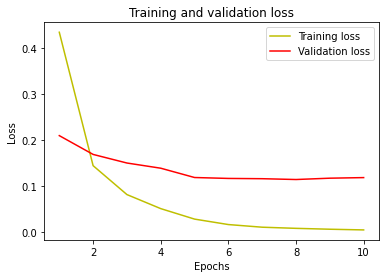

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

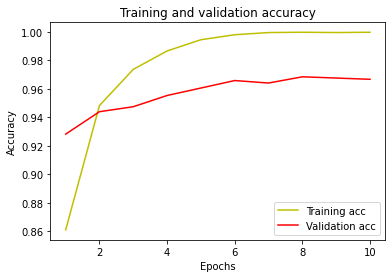

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 1s 779ms/step
The prediction for this image is:  0
The actual label for this image is:  0


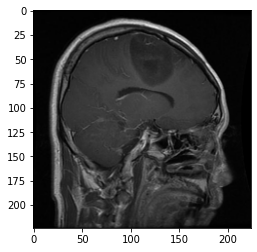

In [ ]:
#model = tf.keras.models.load_model("/content/model_mri.h5")
#Test on single image.
n=10  #Select the index of image to be loaded for testing
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, class)
print("The prediction for this image is: ", np.argmax(model.predict(input_img)))
print("The actual label for this image is: ", np.argmax(y_test[n]))

1/1 [==============================] - 0s 16ms/step
The prediction for this image is:  3


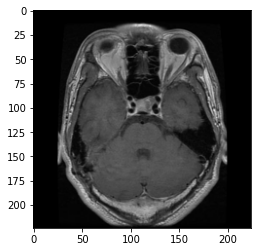

In [ ]:
#Test on single image from other sources.
  
img = '/content/drive/MyDrive/Nickparver_156MB/Testing/pituitary/Te-piTr_0000.jpg'
image = cv2.imread(img)
image = Image.fromarray(image, 'RGB')
image = image.resize((SIZE, SIZE))
plt.imshow(image)
input_img = np.expand_dims(image, axis=0) #Expand dims so the input is (num images, x, y, class)
print("The prediction for this image is: ", np.argmax(model.predict(input_img)))

In [ ]:
#Writing the type of tumor on the MRI image
prediction = np.argmax(model.predict(input_img))
print(prediction)

1/1 [==============================] - 0s 19ms/step
3


In [ ]:
if prediction==0:
  tumor = 'Glioma'
elif prediction==1:
  tumor = 'Meningioma'
elif prediction==2:
  tumor = 'No Tumor'
else:
  tumor = 'pituitary' 
  

In [ ]:
print(tumor)

pituitary


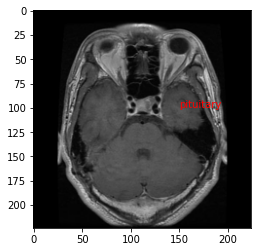

In [ ]:
from matplotlib import colors
import matplotlib.pyplot as plt

img = '/content/drive/MyDrive/Nickparver_156MB/Testing/pituitary/Te-piTr_0000.jpg'
image = cv2.imread(img)
image = Image.fromarray(image, 'RGB')
image = image.resize((SIZE, SIZE))
plt.text(150,100,tumor,{"color":"r"})
plt.imshow(image)

36/36 [==============================] - 5s 153ms/step


[Text(0, 0.5, 'glioma'),
 Text(0, 1.5, 'meningioma'),
 Text(0, 2.5, 'no_tumor'),
 Text(0, 3.5, 'pituitary')]

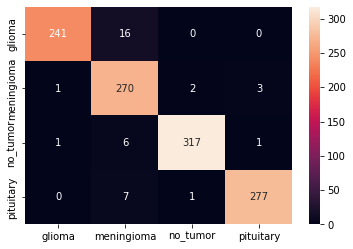

In [ ]:
#Print confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

y_pred = np.argmax(model.predict(X_test), axis=1)
cm=confusion_matrix(np.argmax(y_test, axis=1), y_pred)  
ax = sns.heatmap(cm, annot=True, fmt = 'd')
ax.xaxis.set_ticklabels(['glioma', 'meningioma','no_tumor', 'pituitary'])
ax.yaxis.set_ticklabels(['glioma', 'meningioma','no_tumor', 'pituitary']) 

In [ ]:
#Classifiction Report
classification_report = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=['glioma', 'meningioma','no_tumor', 'pituitary'])
print(classification_report)

              precision    recall  f1-score   support

      glioma       0.99      0.94      0.96       257
  meningioma       0.90      0.98      0.94       276
    no_tumor       0.99      0.98      0.98       325
   pituitary       0.99      0.97      0.98       285

    accuracy                           0.97      1143
   macro avg       0.97      0.97      0.97      1143
weighted avg       0.97      0.97      0.97      1143



In [ ]:
#Segmenting the tumor with U net

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

In [ ]:
 def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [ ]:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

In [ ]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [ ]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    u_model = Model(inputs, outputs, name="U-Net")
    return u_model

In [ ]:
if __name__ == "__main__":
    input_shape = (512, 512, 3)
    u_model = build_unet(input_shape)
    u_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [ ]:
""" Global parameters """
H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

In [ ]:
    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    batch_size = 32 #16 is also there
    lr = 1e-4
    num_epochs = 30
    model_path = os.path.join("files", "model.h5")
    csv_path = os.path.join("files", "log.csv")

In [ ]:
    """ Dataset """
    dataset_path = "/content/drive/MyDrive/Colab Notebooks/Tumor Segmentation"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test : {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

Train: 1852 - 1852
Valid: 616 - 616
Test : 616 - 616


In [ ]:
    """ Model """ 
    #Add IoU, accuracy here
    u_model = build_unet((H, W, 3))
    metrics = [dice_coef, iou]
    u_model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=["accuracy",metrics])

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=False),
    ]

    u_model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

Epoch 1/30
58/58 [==============================] - ETA: 0s - loss: 0.8969 - accuracy: 0.7428 - dice_coef: 0.1033 - iou: 0.0550 
Epoch 1: val_loss improved from inf to 0.97136, saving model to files/model.h5
58/58 [==============================] - 1586s 26s/step - loss: 0.8969 - accuracy: 0.7428 - dice_coef: 0.1033 - iou: 0.0550 - val_loss: 0.9714 - val_accuracy: 0.0152 - val_dice_coef: 0.0286 - val_iou: 0.0145 - lr: 1.0000e-04
Epoch 2/30
58/58 [==============================] - ETA: 0s - loss: 0.7877 - accuracy: 0.9592 - dice_coef: 0.2124 - iou: 0.1192
Epoch 2: val_loss did not improve from 0.97136
58/58 [==============================] - 115s 2s/step - loss: 0.7877 - accuracy: 0.9592 - dice_coef: 0.2124 - iou: 0.1192 - val_loss: 0.9831 - val_accuracy: 0.6034 - val_dice_coef: 0.0168 - val_iou: 0.0085 - lr: 1.0000e-04
Epoch 3/30
58/58 [==============================] - ETA: 0s - loss: 0.7323 - accuracy: 0.9727 - dice_coef: 0.2677 - iou: 0.1548
Epoch 3: val_loss did not improve from 0.

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope 

In [ ]:
if __name__ == "__main__":
 
    """ Loading model """
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
        u_model = tf.keras.models.load_model("files/model.h5")

    """ Dataset """
    path = "/content/drive/MyDrive/Colab Notebooks/Test Tumors/with mask"
    test_img=sorted(glob(os.path.join(path,"MRI" ,"*.png")))
    ground_truth=sorted(glob(os.path.join(path,"Mask" ,"*.png")))
    t=1
    """ Predicting the mask """
    for x, y  in tqdm(zip(test_img,ground_truth), total=len(test_img)):
        """ Extracing the image name. """
        image_name = x.split("/")[-1]

        """ Reading the image """
        img = cv2.imread(x, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (W, H))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        x = img/255.0
        x = x.astype(np.float32)
        x = np.expand_dims(x, axis=0)

        """ Reading the mask """
        img_y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        img_y = cv2.resize(img_y, (W, H))
        img_y = np.expand_dims(img_y, axis=-1) 
        img_y = np.concatenate([img_y, img_y, img_y], axis=-1) 

        """ Predicting the mask. """
        y_pred = u_model.predict(x)[0] > 0.5
        y_pred = y_pred.astype(np.int32)

        """ Saving the predicted mask along with the image and GT """
        save_image_path = f"/content/drive/MyDrive/Colab Notebooks/Results/{image_name}"
        y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)

        sep_line = np.ones((H, 10, 3)) * 255

        output_image = np.concatenate([img, sep_line, img_y, sep_line, y_pred*255], axis=1)
        cv2.imwrite(save_image_path, output_image)

  0%|          | 0/7 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1/7 [00:03<00:20,  3.46s/it]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 2/7 [00:04<00:11,  2.27s/it]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 3/7 [00:06<00:07,  1.83s/it]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 4/7 [00:07<00:04,  1.64s/it]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 5/7 [00:08<00:03,  1.57s/it]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 6/7 [00:10<00:01,  1.50s/it]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 7/7 [00:11<00:00,  1.68s/it]


In [ ]:
#For random image
if __name__ == "__main__":

    """ Loading model """
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
        model = tf.keras.models.load_model("files/model.h5")

    img = cv2.imread("/content/drive/MyDrive/Nickparver_156MB/Testing/meningioma/Te-me_0014.jpg", cv2.IMREAD_COLOR)
    img = cv2.resize(img, (W, H))
    x = img/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)

    y_pred = u_model.predict(x)[0] > 0.7
    y_pred = y_pred.astype(np.int32)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)

    sep_line = np.ones((H, 10, 3)) * 255
    output_img = np.concatenate([img,sep_line,y_pred*255], axis=1)
    cv2.imwrite("Output_d.png", output_img)

1/1 [==============================] - 0s 18ms/step




```
# **Annotate tumor type with Bounding Box**
```





In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
from skimage.measure import label, regionprops, find_contours

In [ ]:
""" Creating a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
""" Convert a mask to border image """
def mask_to_border(mask):
    h, w = mask.shape
    border = np.zeros((h, w))

    contours = find_contours(mask, 128)
    for contour in contours:
        for c in contour:
            x = int(c[0])
            y = int(c[1])
            border[x][y] = 255

    return border

In [ ]:
""" Mask to bounding boxes """
def mask_to_bbox(mask):
    bboxes = []

    mask = mask_to_border(mask)
    lbl = label(mask)
    props = regionprops(lbl)
    for prop in props:
        x1 = prop.bbox[1]
        y1 = prop.bbox[0]

        x2 = prop.bbox[3]
        y2 = prop.bbox[2]

        bboxes.append([x1, y1, x2, y2])

    return bboxes

In [ ]:
def parse_mask(mask):
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)
    return mask

In [ ]:
##Not required

if __name__ == "__main__":
    """ Load the dataset """
    path1 = "/content/drive/MyDrive/Colab Notebooks/Test Tumors/with mask"
    images = sorted(glob(os.path.join(path1, "MRI", "*.png")))
    masks = sorted(glob(os.path.join(path1, "Mask", "*.png")))

    """ Create folder to save images """
    create_dir("results")

    """ Loop over the dataset """
    for x, y in tqdm(zip(images, masks), total=len(images)):
        """ Extract the name """
        name = x.split("/")[-1].split(".")[0]

        """ Read image and mask """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)

        """ Detecting bounding boxes """
        bboxes = mask_to_bbox(y)

        """ marking bounding box on image """
        for bbox in bboxes:
            x = cv2.rectangle(x, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)

        """ Saving the image """
        cat_image = np.concatenate([x, parse_mask(y)], axis=1)
        cv2.imwrite(f"results/{name}.png", cat_image)

100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


In [ ]:
#Annotate the type of tumor

1/1 [==============================] - 0s 18ms/step
The prediction for this image is:  1


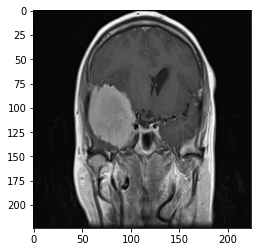

In [ ]:
from matplotlib import colors
import matplotlib.pyplot as plt

#first predict the tumor class
test_mri_path = "/content/drive/MyDrive/Colab Notebooks/Test_SOMC/Meningioma/SOMC_men_11.jpg"
img = test_mri_path
image = cv2.imread(img)
image = Image.fromarray(image, 'RGB')
image = image.resize((SIZE, SIZE))
plt.imshow(image)
input_img = np.expand_dims(image, axis=0) #Expand dims so the input is (num images, x, y, class)
print("The prediction for this image is: ", np.argmax(model.predict(input_img)))



In [ ]:
#then show the tumor type

In [ ]:
prediction = np.argmax(model.predict(input_img))
#print(prediction)
if prediction==0:
  tumor = 'Glioma'
elif prediction==1:
  tumor = 'Meningioma'
elif prediction==2:
  tumor = 'No Tumor'
else:
  tumor = 'pituitary'


print(tumor)

1/1 [==============================] - 0s 17ms/step
Meningioma


In [ ]:
#Now Segment the tumor part

In [ ]:
img = cv2.imread(img, cv2.IMREAD_COLOR)
img = cv2.resize(img, (W, H))
x = img/255.0
x = x.astype(np.float32)
x = np.expand_dims(x, axis=0)


y_pred = u_model.predict(x)[0] > 0.7
y_pred = y_pred.astype(np.int32)
y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)

sep_line = np.ones((H, 10, 3)) * 255
output_img = np.concatenate([img,sep_line,y_pred*255], axis=1)
cv2.imwrite("seg_result.png", output_img)
cv2.imwrite("seg_tumor_mask.png", y_pred*255)#Save this for further use

1/1 [==============================] - 0s 21ms/step


True

In [ ]:
#Create the bounding box 

In [ ]:
images = test_mri_path
img = cv2.imread(images, cv2.IMREAD_COLOR)
img = cv2.resize(img, (256, 256))
#cv2.imwrite("new.jpg",img)

In [ ]:
mask1 = "/content/seg_tumor_mask.png"
mask_1 = cv2.imread(mask1, cv2.IMREAD_GRAYSCALE)
mask_1 = cv2.resize(mask_1, (256,256))#make sure mri and mask sizes are identical

In [ ]:

        #""" Detecting bounding boxes """
bboxes = mask_to_bbox(mask_1)

        #""" marking bounding box on image """
for bbox in bboxes:
      img = cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)

        #""" Saving the image """
cat_image = np.concatenate([img, parse_mask(mask_1)], axis=1)
Tumor = tumor #taken from prediction
cv2.putText(cat_image,Tumor, (bbox[0], bbox[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255))
cv2.imwrite(f"output.png", cat_image)

True